<a href="https://colab.research.google.com/github/EFRA-DH/sgs/blob/main/scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Prepare Resources:

## Imports:

In [1]:
%%capture
import torch
import numpy as np
import pandas as pd
from scipy.stats import shapiro, monte_carlo_test, norm
import matplotlib.pyplot as plt
from matplotlib.table import table as plt_table
from sklearn.metrics import f1_score
from tqdm.autonotebook import tqdm

from typing import List, Callable, Union, Dict

In [2]:
%%capture
# import rouge score
!pip install rouge_score
from rouge_score import rouge_scorer

In [3]:
%%capture
# import LongDocFactScore
!pip install longdocfactscore
from longdocfactscore.ldfacts import LongDocFACTScore

In [4]:
%%capture
# install nltk:
!pip install nltk

# download 'punkt' reslource:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

# import actual requirements:
from nltk.tokenize import PunktSentenceTokenizer, word_tokenize

In [5]:
%%capture
# import BART score:
from urllib.request import urlretrieve
urlretrieve("https://raw.githubusercontent.com/neulab/BARTScore/main/bart_score.py", "bart_score.py")
from bart_score import BARTScorer

## Constants:

In [6]:
SENT_TOKENIZER = PunktSentenceTokenizer()
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cpu')

## Definitions:

In [7]:
from html.parser import HTMLParser

class HTMLSplitter(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.text = ''

    def __call__(self, html:str, window:int, tokenize:Callable[[str], List]=word_tokenize):
        parts, paragraphs, tokens, texts = [], [], [], []

        self.feed(html)
        html = self.get_data()

        # split text in paragraphs:
        part = 0
        cursor = 0
        remaining_tokens = -1
        for paragraph, txt in enumerate(html.split('\n\n')):
            for i,j in SENT_TOKENIZER.span_tokenize(txt):
                sentence = tokenize(txt[i:j+1])
                remaining_tokens -= len(sentence) - 1

                if remaining_tokens <= 0:
                    parts.append(str(part))
                    paragraphs.append(str(paragraph))
                    tokens.append(sentence[:window])
                    texts.append(txt[i:j+1])
                    remaining_tokens = window - len(sentence) + 1

                    part += 1
                    cursor = i

                else:
                    tokens[-1].extend(sentence[:window])
                    texts[-1] = txt[cursor:j+1]

            remaining_tokens = -1

        return {'part':parts, 'paragraph':paragraphs, 'tokens':tokens, 'texts':texts}

    @property
    def ends_with_space(self):
        if len(self.text) == 0: return True
        else: return self.text[-1] in (' ', '\n', '\r', '\t', '>')

    @property
    def ends_with_newline(self):
        if self.text.endswith('\n  - '): return True
        elif len(self.text) == 0: return True
        else: return self.text[-1] in ('\n', '\r', '>')

    def handle_starttag(self, tag, attrs):
        if tag in ('table', 'tr', 'th', 'td'):
            self.text += f'<{tag}>' if self.ends_with_newline else f'\n<{tag}>'

        elif tag == 'b' or tag == 'strong':
            self.text += '**' if self.ends_with_space else ' **'

        elif tag == 'i':
            if not self.ends_with_space:
                self.text += '*' if self.ends_with_space else ' *'

        elif tag == 'li':
            self.text += '  - ' if self.ends_with_newline else '\n  - '

        elif tag == 'p':
            if not self.ends_with_newline:
                self.text += '\n'

        elif tag.startswith('h'):
            self.text += '\n**' if self.ends_with_newline else '\n\n**'

        elif not self.ends_with_space:
            self.text += ' '

    def handle_endtag(self, tag):
        if tag in ('table', 'tr', 'th', 'td'):
            self.text += f'</{tag}>'

        if tag == 'b' or tag == 'strong':
            self.text += '** '

        elif tag == 'i':
            self.text += '* '

        elif tag == 'p':
            if not self.ends_with_space:
                self.text += '\n'

        elif tag.startswith('h'):
            self.text += '**\n'

        elif not self.ends_with_space:
            self.text += ' '

    def handle_data(self, data):
        self.text += data.replace('\n', '').replace('\r', '').strip()

    def get_data(self):
        return self.text.strip()


# 2. Compute Metrics:

In [8]:
# load data:
!gdown 15go23FfbJqJ2kEe-WlWXoB6n96BtbErQ
data = pd.read_csv('manual_and_llama70b_summ.csv').fillna('')

data.head()

Downloading...
From (original): https://drive.google.com/uc?id=15go23FfbJqJ2kEe-WlWXoB6n96BtbErQ
From (redirected): https://drive.google.com/uc?id=15go23FfbJqJ2kEe-WlWXoB6n96BtbErQ&confirm=t&uuid=d3b01789-6bc5-447e-95cc-5383ec225e21
To: /content/manual_and_llama70b_summ.csv
100% 1.30G/1.30G [00:22<00:00, 57.9MB/s]


,dataset,english_content_url,english_summary,english_title,original_content_url,original_summary,original_title,post_id,source_id,source_name,topics,types,html,cleaned_html,llama70b_title,llama70b_summary
0,manual_summary,gs://c-labs1-efra/english/7472062c-1335-488e-b...,Meat processors are in talks with the governme...,Carbon dioxide 'threatens food security' says ...,gs://c-labs1-efra/original/7472062c-1335-488e-...,Meat processors are in talks with the governme...,Carbon dioxide 'threatens food security' says ...,7472062c-1335-488e-b319-4f2e73da19b5,004bbb24-2d5e-4215-b76c-c947f277771f,BBC,[{'id': '57097913-1379-4424-a4fb-d619cf64e535'...,[{'id': '6a7393f6-21c9-4622-8996-70361417c714'...,"<div data-digico-rtf-version=""1.0""><figure><im...",Getty Images \nPoultry producers said the shor...,UK Meat Industry Faces Carbon Dioxide Shortage...,The UK meat industry is facing a crisis due to...
1,manual_summary,gs://c-labs1-efra/english/c5c108fa-9b42-4fc1-a...,A new type of recyclable meat packaging tray d...,Plastic pollution: New meat tray 'could save t...,gs://c-labs1-efra/original/c5c108fa-9b42-4fc1-...,A new type of recyclable meat packaging tray d...,Plastic pollution: New meat tray 'could save t...,c5c108fa-9b42-4fc1-aa2b-aedbafb0f513,004bbb24-2d5e-4215-b76c-c947f277771f,BBC,[{'id': '57097913-1379-4424-a4fb-d619cf64e535'...,[{'id': '6a7393f6-21c9-4622-8996-70361417c714'...,"<div data-digico-rtf-version=""1.0""><figure></f...",**A new type of recyclable meat packaging tray...,Revolutionary Recyclable Meat Packaging Tray R...,A Swansea University student has designed a 10...
2,manual_summary,gs://c-labs1-efra/english/1b5fd7b6-f92b-447a-8...,Racehorses in Great Britain will not be allowe...,New rules aimed at ensuring racehorses do not ...,gs://c-labs1-efra/original/1b5fd7b6-f92b-447a-...,Racehorses in Great Britain will not be allowe...,New rules aimed at ensuring racehorses do not ...,1b5fd7b6-f92b-447a-8d8d-877af6b7171b,004bbb24-2d5e-4215-b76c-c947f277771f,BBC,[{'id': '0e3de27e-3394-4477-86de-898fde8e5566'...,[{'id': '6a7393f6-21c9-4622-8996-70361417c714'...,"<div data-digico-rtf-version=""1.0""><figure><im...","Image caption, The new rule change applies to ...",UK Racehorses to be Signed Out of Food Chain t...,The British Horseracing Authority (BHA) has in...
3,manual_summary,gs://c-labs1-efra/english/92ea9206-0817-4045-9...,The end of the Government's deal with CF ferti...,Concerns over food shortages as CO2 deal ends,gs://c-labs1-efra/original/92ea9206-0817-4045-...,The end of the Government's deal with CF ferti...,Concerns over food shortages as CO2 deal ends,92ea9206-0817-4045-944f-d8c2e70d5238,004bbb24-2d5e-4215-b76c-c947f277771f,BBC,[{'id': '0e3de27e-3394-4477-86de-898fde8e5566'...,[{'id': '6a7393f6-21c9-4622-8996-70361417c714'...,"<div data-digico-rtf-version=""1.0""><figure><im...",**UK food and drink firms say they remain conc...,UK Food and Drink Firms Concerned About Supply...,UK food and drink firms are worried about pote...
4,manual_summary,gs://c-labs1-efra/english/ab4fcc57-e029-4c7a-a...,"The new agreement, called the Windsor Framewor...",EU and UK strike new deal over post-Brexit tra...,gs://c-labs1-efra/original/ab4fcc57-e029-4c7a-...,"The new agreement, called the Windsor Framewor...",EU and UK strike new deal over post-Brexit tra...,ab4fcc57-e029-4c7a-a7bd-f3a675bb1d0c,724d0920-41e4-4b5e-bf2a-717df4e75359,CNN,[{'id': '0e3de27e-3394-4477-86de-898fde8e5566'...,[{'id': '6a7393f6-21c9-4622-8996-70361417c714'...,"<div data-digico-rtf-version=""1.0""><figure><pi...",London CNN —\nBritain and the European Union h...,UK and EU Reach Agreement on New Trade Rules f...,"The UK and EU have reached a deal, known as th..."


### ROUGE:

In [11]:
def score(manual_summaries:List[str], automated_summaries:List[str], rouge_types:List[str]=['rouge1', 'rougeL']) -> pd.DataFrame:
    """
    Compute rouge metrics for summary evaluation.

    :param manual_summaries: List of manual summaries.
    :param automated_summaries: List of automated summaries.
    :param rouge_types: List of the names of specific ROUGE-score types (default: ['rouge1', 'rougeL']).

    :return: Pandas DataFrame of scores.
    """
    # just to be sure...
    assert len(manual_summaries) == len(automated_summaries)

    # compute scores:
    scores = {}

    # compute ROUGE-F1:
    scorer = rouge_scorer.RougeScorer(rouge_types, use_stemmer=True)
    for key in rouge_types: scores[key] = []
    for m, a  in tqdm(zip(manual_summaries, automated_summaries), total=len(manual_summaries), desc='Computing ROUGE'):
        rouge = scorer.score(m, a)
        for key in rouge: scores[key].append(rouge[key].fmeasure)

    return pd.DataFrame(scores)

In [12]:
scores_rouge = score(data['english_summary'], data['llama70b_summary'])
scores_rouge.to_csv('scores_rouge.csv')

scores_rouge.head()

Computing ROUGE:   0%|          | 0/2093 [00:00<?, ?it/s]

,rouge1,rougeL
0,0.475610,0.219512
1,0.535714,0.250000
2,0.600000,0.428571
3,0.373134,0.164179
4,0.367188,0.234375


## Overall Summary Metrics:

In [ ]:
def score(originals:List[str], summaries:List[str], rouge_types:List[str]=['rouge1', 'rougeL'], device:Union[str, torch.device, int]=DEVICE) -> pd.DataFrame:
    """
    Compute common metrics for summary evaluation.

    :param originals: List of original texts.
    :param summaries: List of original summaries.
    :param rouge_types: List of the names of specific ROUGE-score types (default: ['rouge1', 'rougeL']).
    :param device: Torch device to be used with BART-score.

    :return: Pandas DataFrame of scores.
    """
    # just to be sure...
    assert len(originals) == len(summaries)

    # compute scores:
    scores = {}

    # compute ROUGE-F1:
    scorer = rouge_scorer.RougeScorer(rouge_types, use_stemmer=True)
    for key in rouge_types: scores[key] = []
    for o, s in tqdm(zip(originals, summaries), total=len(originals), desc='Computing ROUGE'):
        rouge = scorer.score(o, s)
        for key in rouge: scores[key].append(rouge[key].fmeasure)

    # compute Long-Doc-Facts-Score:
    scorer = LongDocFACTScore(device=device)
    scores['ldfacts'] = scorer.score_src_hyp_long(originals, summaries)

    return pd.DataFrame(scores)

In [ ]:
scores_manual = score(data['cleaned_html'], data['english_summary'])
scores_manual.to_csv('scores_manual.csv')

scores_manual.head()

Computing ROUGE:   0%|          | 0/5 [00:00<?, ?it/s]

,rouge1,rougeL,ldfacts
0,0.151762,0.081301,-3.342417
1,0.462025,0.408228,-2.116693
2,0.136662,0.120894,-2.470614
3,0.127527,0.077760,-4.562559
4,0.153998,0.132280,-1.745450


from matplotlib import pyplot as plt
_df_0['rouge1'].plot(kind='hist', bins=20, title='rouge1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['rougeL'].plot(kind='hist', bins=20, title='rougeL')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['ldfacts'].plot(kind='hist', bins=20, title='ldfacts')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='rouge1', y='rougeL', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='rougeL', y='ldfacts', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5['rouge1'].plot(kind='line', figsize=(8, 4), title='rouge1')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_6['rougeL'].plot(kind='line', figsize=(8, 4), title='rougeL')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_7['ldfacts'].plot(kind='line', figsize=(8, 4), title='ldfacts')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
scores_llama70b = score(data['cleaned_html'], data['llama70b_summary'])
scores_llama70b.to_csv('scores_llama70b.csv')

scores_llama70b.head()

Computing ROUGE:   0%|          | 0/5 [00:00<?, ?it/s]

,rouge1,rougeL,ldfacts
0,0.238220,0.157068,-3.681248
1,0.257143,0.157143,-3.223632
2,0.191677,0.131148,-2.346488
3,0.209408,0.169954,-2.512157
4,0.091837,0.073469,-3.759611


## Paragraph-Based Metrics:

In [ ]:
class ParagraphScorer:
    def __init__(self, score:str='rougeL', max_paragraph_size:Union[int, float, None]=None, device:Union[str, torch.device, int]=DEVICE):
        """
        Create a new paragraph based scorer.

        :param score: Base score.
        :param max_paragraph_size: Maximum size of the chunks.
        :param device: Torch device to be used with BART-score.
        """

        if score.startswith('rouge'):
            self.max_paragraph_size = max_paragraph_size
            scorer                  = rouge_scorer.RougeScorer([score], use_stemmer=True)
            self.scoring_fcn        = lambda originals, summaries: [scorer.score(o, s)[score].fmeasure for o, s in zip(originals, summaries)]

        elif score == 'bart':
            self.max_paragraph_size = max_paragraph_size if max_paragraph_size is not None else 1024
            scorer                  = BARTScorer(device=device, max_length=max_paragraph_size)
            self.scoring_fcn        = lambda originals, summaries: np.exp(scorer.score(originals, summaries))

        else: raise ValueError(f'Unknown score "{score}"')

    def __call__(self, originals:List[str], summaries:List[str], **kwargs):
        """
        Compute scores per chunk in the original document and report the percentage of chunks needed to get half the total score.

        :param originals: List of original texts.
        :param summaries: List of original summaries.
        :param **kwargs:  Optional keyword arguments for the underlying HTMLParser-class.

        :return: Pandas DataFrame of scores.
        """
        return self.score(originals, summaries, **kwargs)

    def score(self, originals:List[str], summaries:List[str], **kwargs):
        """
        Compute scores per chunk in the original document and report the percentage of chunks needed to get half the total score.

        :param originals: List of original texts.
        :param summaries: List of original summaries.
        :param **kwargs:  Optional keyword arguments for the underlying HTMLParser-class.

        :return: Pandas DataFrame of scores.
        """
        scores = []
        for original, summary in zip(tqdm(originals), summaries):
            splitter = HTMLSplitter()

            n = self.max_paragraph_size
            if n is None: n = len(word_tokenize(summary))
            elif isinstance(n, float) and n <= 1.: n = int(n*len(word_tokenize(original)))

            parts_text = splitter(original, n, **kwargs)
            scores_text = self.scoring_fcn(parts_text['texts'], [summary]*len(parts_text['texts']))

            scores.append(np.mean(np.cumsum(np.sort(scores_text)) > (.5*np.sum(scores_text))))

        return scores

In [ ]:
def score_paragraphs(originals:List[str], summaries:List[str], max_paragraph_size:int=20, rouge_types:List[str]=['rouge1', 'rougeL'], device:Union[str, torch.device, int]=DEVICE) -> pd.DataFrame:
    """
    Compute chunk based metrics for summary evaluation.

    :param originals: List of original texts.
    :param summaries: List of original summaries.
    :param rouge_types: List of the names of specific ROUGE-score types (default: ['rouge1', 'rougeL']).
    :param device: Torch device to be used with BART-score.

    :return: Pandas DataFrame of scores.
    """
    # just to be sure...
    assert len(originals) == len(summaries)

    # compute scores:
    scores = {}

    # compute ROUGE-F1:
    for metric in rouge_types:
      scorer = ParagraphScorer(metric, max_paragraph_size=max_paragraph_size)
      scores[metric] = scorer.score(originals, summaries)

    # compute BART-Score:
    scorer = ParagraphScorer('bart', max_paragraph_size=max_paragraph_size)
    scores['bart'] = scorer.score(originals, summaries)

    return pd.DataFrame(scores)

In [ ]:
density_manual = score_paragraphs(data['html'], data['english_summary'])
density_manual.to_csv('density_manual.csv')

density_manual.head()

In [ ]:
density_llama70b = score_paragraphs(data['html'], data['llama70b_summary'])
density_llama70b.to_csv('density_llama70b.csv')

density_llama70b.head()

# Plots and Tables:

In [23]:
titles = {
    'rouge1': 'Rouge-1',
    'rougeL': 'Rouge-L',
    'ldfacts': 'Long-Doc-Facts-Score',
    'bart': 'BART-Score'
}

## 1. Similarity:

In [24]:
scores_rouge = pd.read_csv('scores_rouge.csv', index_col=0).fillna(0.)
scores_rouge.describe()

,rouge1,rougeL
count,2093.000000,2093.000000
mean,0.425633,0.296879
std,0.127995,0.114700
min,0.000000,0.000000
25%,0.348315,0.216867
50%,0.425339,0.280702
75%,0.510204,0.366667
max,0.977695,0.977695


In [15]:
scores_manual = pd.read_csv('scores_manual.csv', index_col=0).fillna(0.)
scores_manual.describe()

,rouge1,rougeL,ldfacts
count,2093.000000,2093.000000,2093.000000
mean,0.144436,0.126685,-2.687617
std,0.161861,0.149203,1.345769
min,0.000000,0.000000,-8.739442
25%,0.020713,0.018351,-3.671271
50%,0.079938,0.067797,-2.642063
75%,0.224490,0.184906,-1.542675
max,1.000000,1.000000,0.000000


In [16]:
scores_llama70b = pd.read_csv('scores_llama70b.csv', index_col=0).fillna(0.)
scores_llama70b.describe()

,rouge1,rougeL,ldfacts
count,2093.000000,2093.000000,2093.000000
mean,0.132693,0.100577,-3.188854
std,0.122558,0.094119,0.572175
min,0.000237,0.000233,-6.194722
25%,0.023805,0.019809,-3.546408
50%,0.100870,0.073469,-3.176870
75%,0.221477,0.159265,-2.817284
max,0.662338,0.623377,-1.175319


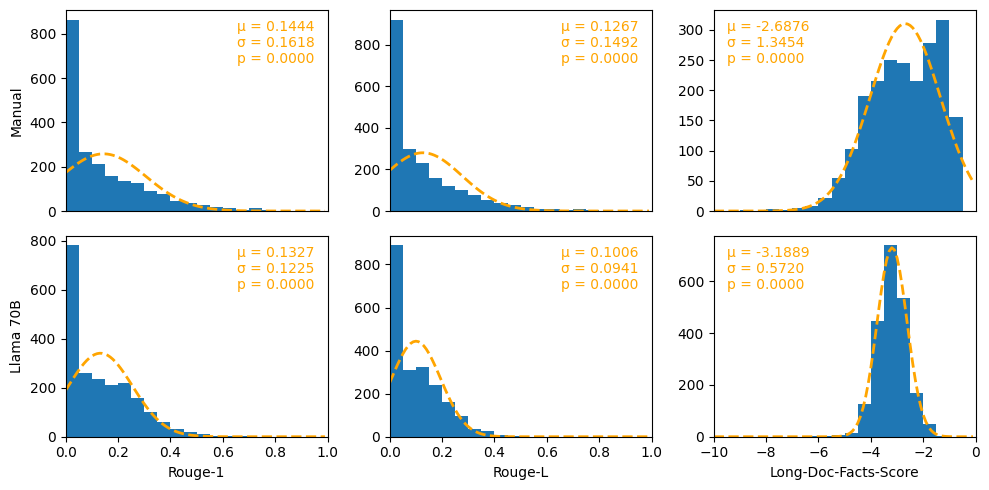

\begin{tabular}{lrrr}
\toprule
 & Rouge-1 & Rouge-L & Long-Doc-Facts-Score \\
\midrule
Llama 70B: μ & 0.132693 & 0.100577 & -3.188854 \\
Llama 70B: σ & 0.122529 & 0.094096 & 0.572039 \\
Llama 70B: p-value & 0.000000 & 0.000000 & 0.000000 \\
\bottomrule
\end{tabular}



In [ ]:
# create figure:
fig, axs = plt.subplots(2, 3, figsize=(10, 5))

# plot columns:
table = {}
for i, scores in enumerate([scores_manual, scores_llama70b]):
    row = 'Manual' if i == 0 else 'Llama 70B'
    for j, col in enumerate(scores.columns):
        ax = axs[i, j]

        if col.startswith('rouge'): x_min, x_max, x_step = 0., 1., .01
        else:                       x_min, x_max, x_step = -10., 0., .1
        bins = np.arange(x_min, x_max, x_step*5.)
        x = np.arange(x_min, x_max, x_step)

        # plot histogram:
        ax.hist(scores[col], bins=bins)

        # compute Shapiro-Wilk:
        W, p = shapiro(scores[col])

        # fit and plot normal distribution:
        mu, std = norm.fit(scores[col])
        y = norm.pdf(x, mu, std) * (len(scores) * x_step * 5.)
        ax.plot(x, y, ls='dashed', lw=2, c='orange')

        # print fit characteristics:
        ax.text(.95 if col.startswith('rouge') else -9.5, .95*ax.get_ylim()[1],
            f'μ = {mu:.4f}\nσ = {std:.4f}\np = {p:.4f}',
            horizontalalignment='right' if col.startswith('rouge') else 'left',
            verticalalignment='top',
            c='orange'
        )

        # layout:
        ax.set_xlim(x_min, x_max)
        if i == 0: ax.set_xticks([])
        else: ax.set_xlabel(titles[col])
        if j == 0: ax.set_ylabel(row)

        table[titles[col]] = {row + ': μ':mu, row + ': σ':std, row + ': p-value':p}

plt.tight_layout()
plt.savefig('similarity.pdf')
plt.show()

# print latex table:
print(pd.DataFrame(table).to_latex())

## 2. Density:

In [ ]:
density_manual = pd.read_csv('density_manual.csv', index_col=0).fillna(0.)
density_manual.describe()

,rouge1,rougeL
count,2093.000000,2093.000000
mean,0.283592,0.276014
std,0.071930,0.072751
min,0.000000,0.000000
25%,0.250000,0.237569
50%,0.285714,0.274510
75%,0.319149,0.311475
max,1.000000,1.000000


In [ ]:
density_llama70b = pd.read_csv('density_llama70b.csv', index_col=0).fillna(0.)
density_llama70b.describe()

,rouge1,rougeL,bart
count,2093.000000,2093.000000,2093.000000
mean,0.306154,0.313698,0.314039
std,0.073769,0.068919,0.087595
min,0.033505,0.041237,0.021661
25%,0.263158,0.276596,0.266667
50%,0.306667,0.313433,0.330097
75%,0.340000,0.350000,0.368421
max,1.000000,1.000000,1.000000


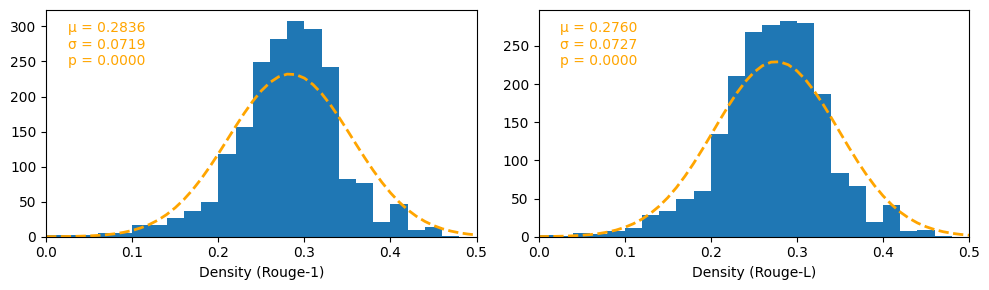

\begin{tabular}{lrr}
\toprule
 & rouge1 & rougeL \\
\midrule
μ & 0.283592 & 0.276014 \\
σ & 0.071912 & 0.072734 \\
p-value & 0.000000 & 0.000000 \\
\bottomrule
\end{tabular}



In [ ]:
# create figure:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

# plot columns:
table = {}
for ax, col in zip(axs, density_manual.columns):
    n_bins = 50
    x = np.arange(0., 1.,.01)

    # plot histogram:
    ax.hist(density_manual[col], bins=n_bins)

    # compute Shapiro-Wilk:
    W, p = shapiro(density_manual[col])

    # fit and plot normal distribution:
    mu, std = norm.fit(density_manual[col])
    y = norm.pdf(x, mu, std) * (len(density_manual) / n_bins)
    ax.plot(x, y, ls='dashed', lw=2, c='orange')

    # print fit characteristics:
    ax.text(.025, .95*ax.get_ylim()[1],
        f'μ = {mu:.4f}\nσ = {std:.4f}\np = {p:.4f}',
        horizontalalignment='left',
        verticalalignment='top',
        c='orange'
    )

    # layout:
    ax.set_xlim(0, .5)
    ax.set_xlabel(f'Density ({titles[col]})')

    table[col] = {'μ':mu, 'σ':std, 'p-value':p}

plt.tight_layout()
plt.savefig('density_manual.pdf')
plt.show()

# print latex table:
print(pd.DataFrame(table).to_latex())

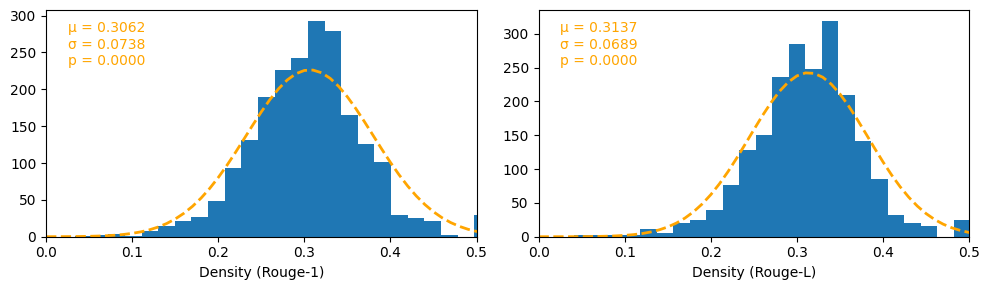

\begin{tabular}{lrr}
\toprule
 & rouge1 & rougeL \\
\midrule
μ & 0.306154 & 0.313698 \\
σ & 0.073752 & 0.068903 \\
p-value & 0.000000 & 0.000000 \\
\bottomrule
\end{tabular}



In [ ]:
# create figure:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

# plot columns:
table = {}
for ax, col in zip(axs, density_llama70b.columns):
    n_bins = 50
    x = np.arange(0., 1.,.01)

    # plot histogram:
    ax.hist(density_llama70b[col], bins=n_bins)

    # compute Shapiro-Wilk:
    W, p = shapiro(density_llama70b[col])

    # fit and plot normal distribution:
    mu, std = norm.fit(density_llama70b[col])
    y = norm.pdf(x, mu, std) * (len(density_llama70b) / n_bins)
    ax.plot(x, y, ls='dashed', lw=2, c='orange')

    # print fit characteristics:
    ax.text(.025, .95*ax.get_ylim()[1],
        f'μ = {mu:.4f}\nσ = {std:.4f}\np = {p:.4f}',
        horizontalalignment='left',
        verticalalignment='top',
        c='orange'
    )

    # layout:
    ax.set_xlim(0, .5)
    ax.set_xlabel(f'Density ({titles[col]})')

    table[col] = {'μ':mu, 'σ':std, 'p-value':p}

plt.tight_layout()
plt.savefig('density_llama70b.pdf')
plt.show()

# print latex table:
print(pd.DataFrame(table).to_latex())

## 3. Per Source Type:

In [18]:
types = np.array([eval(s)[0]['name'] for s in data['types'].values], dtype=object)

Rouge:

In [21]:
scores_rouge_per_type = {}
for t in np.unique(types):
    scores_rouge_per_type[t] = scores_rouge[types==t]
    print(f'{t}:\n{scores_rouge_per_type[t].describe()}\n\n')

Guidance:
           rouge1      rougeL
count  288.000000  288.000000
mean     0.410041    0.283959
std      0.120444    0.108622
min      0.026667    0.026667
25%      0.335333    0.207532
50%      0.415442    0.272286
75%      0.492200    0.354945
max      0.796610    0.745763


News:
            rouge1       rougeL
count  1320.000000  1320.000000
mean      0.429901     0.298784
std       0.120827     0.110680
min       0.000000     0.000000
25%       0.354167     0.219800
50%       0.432216     0.283582
75%       0.509439     0.363636
max       0.827225     0.757062


Regulation:
           rouge1      rougeL
count  352.000000  352.000000
mean     0.425244    0.303405
std      0.142473    0.123213
min      0.000000    0.000000
25%      0.332949    0.215609
50%      0.423902    0.287556
75%      0.522859    0.382790
max      0.761062    0.743363


Scientific:
           rouge1      rougeL
count  133.000000  133.000000
mean     0.418076    0.288679
std      0.165748    0.139613
min   

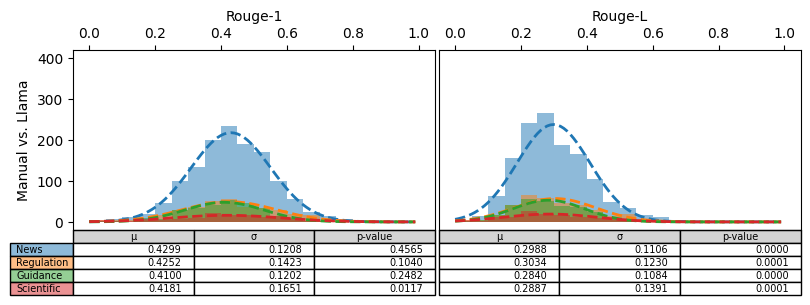

In [33]:
# create figure:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

# plot columns:
colors = {'News':None, 'Regulation':None, 'Guidance':None, 'Scientific':None}
for i, col in enumerate(['rouge1', 'rougeL']):
    tab = []
    tab_col_names = ['μ', 'σ', 'p-value']
    tab_row_names = ['News', 'Regulation', 'Guidance', 'Scientific']
    ax = axs[i]

    for source_type in tab_row_names:
        scores = scores_rouge_per_type[source_type]

        if col.startswith('rouge'): x_min, x_max, x_step = 0., 1., .01
        else:                       x_min, x_max, x_step = -10., 0., .1
        bins = np.arange(x_min, x_max, x_step*5.)
        x = np.arange(x_min, x_max, x_step)

        # plot histogram:
        _, _, bars = ax.hist(scores[col], bins=bins, alpha=.5, color=colors[source_type])
        if colors[source_type] is None: colors[source_type] = bars[0].get_facecolor()

        # compute Shapiro-Wilk:
        W, p = shapiro(scores[col])

        # fit and plot normal distribution:
        mu, std = norm.fit(scores[col])
        y = norm.pdf(x, mu, std) * (len(scores) * x_step * 5.)
        ax.plot(x, y, ls='dashed', lw=2, alpha=1., color=colors[source_type])

        # layout:
        ax.set_xlim(x_min-.05*(x_max-x_min), x_max+.05*(x_max-x_min))
        ax.set_ylim(-20, 420)
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position('top')
        ax.set_xlabel(titles[col])
        if i == 0: ax.set_ylabel('Manual vs. Llama')
        else: ax.set_yticks([])

        tab.append([f'{mu:.4f}', f'{std:.4f}', f'{p:.4f}'])

    table = plt_table(ax, cellText=tab, rowLabels=tab_row_names if i == 0 else None, rowColours=[colors[name] for name in tab_row_names] if i == 0 else None, colLoc='center', colLabels=tab_col_names, colColours=['lightgray']*len(tab_col_names))
    table.set_fontsize(7)

plt.subplots_adjust(wspace=.01, top=.85, bottom=.25, left=.08, right=.99)
plt.savefig('similarity_per_type_rouge.pdf')
plt.show()

Manual:

In [19]:
scores_manual_per_type = {}
for t in np.unique(types):
    scores_manual_per_type[t] = scores_manual[types==t]
    print(f'{t}:\n{scores_manual_per_type[t].describe()}\n\n')

Guidance:
           rouge1      rougeL     ldfacts
count  288.000000  288.000000  288.000000
mean     0.065449    0.057107   -2.775598
std      0.099826    0.088104    1.434182
min      0.000082    0.000082   -7.653493
25%      0.010382    0.009855   -3.896163
50%      0.027050    0.024581   -2.720827
75%      0.073874    0.065475   -1.523005
max      0.755056    0.710112   -0.255291


News:
            rouge1       rougeL      ldfacts
count  1320.000000  1320.000000  1320.000000
mean      0.186014     0.164073    -2.637098
std       0.168899     0.158804     1.301721
min       0.000177     0.000115    -8.739442
25%       0.045498     0.038779    -3.566807
50%       0.142619     0.118839    -2.605498
75%       0.278709     0.244254    -1.506419
max       1.000000     1.000000    -0.305414


Regulation:
           rouge1      rougeL     ldfacts
count  352.000000  352.000000  352.000000
mean     0.084757    0.070015   -2.901433
std      0.117562    0.094511    1.405379
min      0.000076

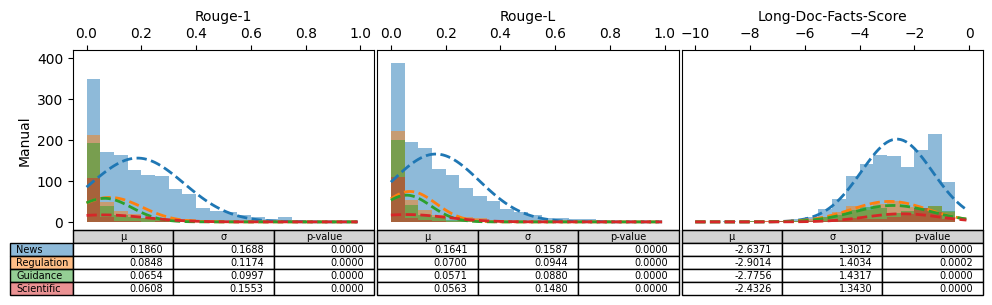

In [ ]:
# create figure:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))

# plot columns:
colors = {'News':None, 'Regulation':None, 'Guidance':None, 'Scientific':None}
for i, col in enumerate(['rouge1', 'rougeL', 'ldfacts']):
    tab = []
    tab_col_names = ['μ', 'σ', 'p-value']
    tab_row_names = ['News', 'Regulation', 'Guidance', 'Scientific']
    ax = axs[i]

    for source_type in tab_row_names:
        scores = scores_manual_per_type[source_type]

        if col.startswith('rouge'): x_min, x_max, x_step = 0., 1., .01
        else:                       x_min, x_max, x_step = -10., 0., .1
        bins = np.arange(x_min, x_max, x_step*5.)
        x = np.arange(x_min, x_max, x_step)

        # plot histogram:
        _, _, bars = ax.hist(scores[col], bins=bins, alpha=.5, color=colors[source_type])
        if colors[source_type] is None: colors[source_type] = bars[0].get_facecolor()

        # compute Shapiro-Wilk:
        W, p = shapiro(scores[col])

        # fit and plot normal distribution:
        mu, std = norm.fit(scores[col])
        y = norm.pdf(x, mu, std) * (len(scores) * x_step * 5.)
        ax.plot(x, y, ls='dashed', lw=2, alpha=1., color=colors[source_type])

        # layout:
        ax.set_xlim(x_min-.05*(x_max-x_min), x_max+.05*(x_max-x_min))
        ax.set_ylim(-20, 420)
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position('top')
        ax.set_xlabel(titles[col])
        if i == 0: ax.set_ylabel('Manual')
        else: ax.set_yticks([])

        tab.append([f'{mu:.4f}', f'{std:.4f}', f'{p:.4f}'])

    table = plt_table(ax, cellText=tab, rowLabels=tab_row_names if i == 0 else None, rowColours=[colors[name] for name in tab_row_names] if i == 0 else None, colLoc='center', colLabels=tab_col_names, colColours=['lightgray']*len(tab_col_names))
    table.set_fontsize(7)

plt.subplots_adjust(wspace=.01, top=.85, bottom=.25, left=.08, right=.99)
plt.savefig('similarity_per_type_manual.pdf')
plt.show()

Llama - 70B:

In [ ]:
scores_llama70b_per_type = {}
for t in np.unique(types):
    scores_llama70b_per_type[t] = scores_llama70b[types==t]
    print(f'{t}:\n{scores_llama70b_per_type[t].describe()}\n\n')

Guidance:
           rouge1      rougeL     ldfacts
count  288.000000  288.000000  288.000000
mean     0.068422    0.053272   -3.319716
std      0.086564    0.068691    0.577447
min      0.000237    0.000233   -4.877737
25%      0.013887    0.011918   -3.720087
50%      0.035043    0.028250   -3.351611
75%      0.090430    0.069197   -2.974448
max      0.611399    0.569948   -1.175319


News:
            rouge1       rougeL      ldfacts
count  1320.000000  1320.000000  1320.000000
mean      0.168215     0.126483    -3.175162
std       0.122412     0.094771     0.562950
min       0.000417     0.000364    -6.194722
25%       0.056975     0.042531    -3.516978
50%       0.163232     0.117466    -3.152452
75%       0.250931     0.187556    -2.808373
max       0.662338     0.623377    -1.250514


Regulation:
           rouge1      rougeL     ldfacts
count  352.000000  352.000000  352.000000
mean     0.086643    0.068319   -3.196161
std      0.103961    0.080193    0.596080
min      0.000298

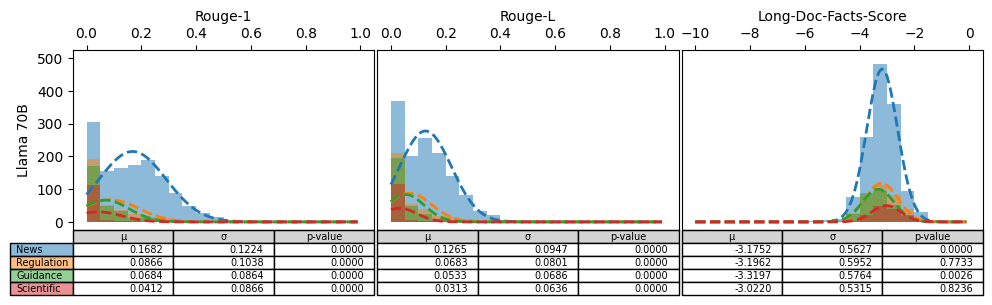

In [ ]:
# create figure:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))

# plot columns:
colors = {'News':None, 'Regulation':None, 'Guidance':None, 'Scientific':None}
for i, col in enumerate(['rouge1', 'rougeL', 'ldfacts']):
    tab = []
    tab_col_names = ['μ', 'σ', 'p-value']
    tab_row_names = ['News', 'Regulation', 'Guidance', 'Scientific']
    ax = axs[i]

    for source_type in tab_row_names:
        scores = scores_llama70b_per_type[source_type]

        if col.startswith('rouge'): x_min, x_max, x_step = 0., 1., .01
        else:                       x_min, x_max, x_step = -10., 0., .1
        bins = np.arange(x_min, x_max, x_step*5.)
        x = np.arange(x_min, x_max, x_step)

        # plot histogram:
        _, _, bars = ax.hist(scores[col], bins=bins, alpha=.5, color=colors[source_type])
        if colors[source_type] is None: colors[source_type] = bars[0].get_facecolor()

        # compute Shapiro-Wilk:
        W, p = shapiro(scores[col])

        # fit and plot normal distribution:
        mu, std = norm.fit(scores[col])
        y = norm.pdf(x, mu, std) * (len(scores) * x_step * 5.)
        ax.plot(x, y, ls='dashed', lw=2, alpha=1., color=colors[source_type])

        # layout:
        ax.set_xlim(x_min-.05*(x_max-x_min), x_max+.05*(x_max-x_min))
        ax.set_ylim(-25, 525)
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position('top')
        ax.set_xlabel(titles[col])
        if i == 0: ax.set_ylabel('Llama 70B')
        else: ax.set_yticks([])

        tab.append([f'{mu:.4f}', f'{std:.4f}', f'{p:.4f}'])

    table = plt_table(ax, cellText=tab, rowLabels=tab_row_names if i == 0 else None, rowColours=[colors[name] for name in tab_row_names] if i == 0 else None, colLoc='center', colLabels=tab_col_names, colColours=['lightgray']*len(tab_col_names))
    table.set_fontsize(7)

plt.subplots_adjust(wspace=.01, top=.85, bottom=.25, left=.08, right=.99)
plt.savefig('similarity_per_type_llama70b.pdf')
plt.show()

Density Manual:

In [ ]:
density_manual_per_type = {}
for t in np.unique(types):
    density_manual_per_type[t] = density_manual[types==t]
    print(f'{t}:\n{density_manual_per_type[t].describe()}\n\n')

Guidance:
           rouge1      rougeL
count  288.000000  288.000000
mean     0.271725    0.272264
std      0.056928    0.057392
min      0.054393    0.054393
25%      0.243349    0.241935
50%      0.274265    0.279706
75%      0.304348    0.306434
max      0.500000    0.428571


News:
            rouge1       rougeL
count  1320.000000  1320.000000
mean      0.296645     0.282218
std       0.073418     0.076526
min       0.027027     0.027027
25%       0.261872     0.240000
50%       0.295702     0.280152
75%       0.333333     0.318182
max       1.000000     1.000000


Regulation:
           rouge1      rougeL
count  352.000000  352.000000
mean     0.259698    0.264682
std      0.066636    0.068431
min      0.033505    0.041237
25%      0.222222    0.223293
50%      0.258775    0.264347
75%      0.294247    0.305613
max      0.666667    0.666667


Scientific:
           rouge1      rougeL
count  133.000000  133.000000
mean     0.242988    0.252550
std      0.063937    0.066606
min   

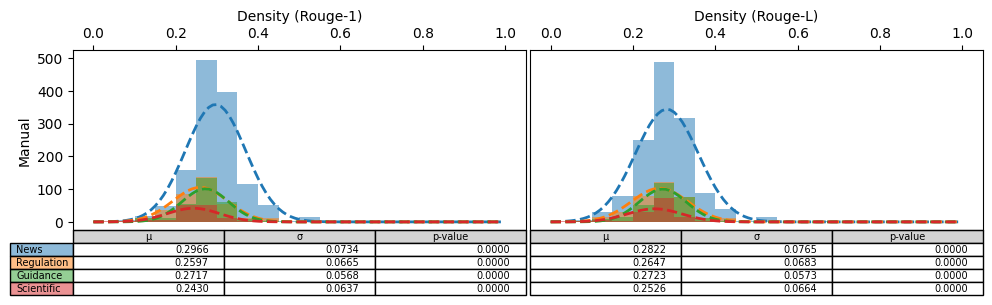

In [ ]:
# create figure:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

# plot columns:
colors = {'News':None, 'Regulation':None, 'Guidance':None, 'Scientific':None}
for i, col in enumerate(['rouge1', 'rougeL']):
    tab = []
    tab_col_names = ['μ', 'σ', 'p-value']
    tab_row_names = ['News', 'Regulation', 'Guidance', 'Scientific']
    ax = axs[i]

    for source_type in tab_row_names:
        scores = density_manual_per_type[source_type]

        if col.startswith('rouge'): x_min, x_max, x_step = 0., 1., .01
        else:                       x_min, x_max, x_step = -10., 0., .1
        bins = np.arange(x_min, x_max, x_step*5.)
        x = np.arange(x_min, x_max, x_step)

        # plot histogram:
        _, _, bars = ax.hist(scores[col], bins=bins, alpha=.5, color=colors[source_type])
        if colors[source_type] is None: colors[source_type] = bars[0].get_facecolor()

        # compute Shapiro-Wilk:
        W, p = shapiro(scores[col])

        # fit and plot normal distribution:
        mu, std = norm.fit(scores[col])
        y = norm.pdf(x, mu, std) * (len(scores) * x_step * 5.)
        ax.plot(x, y, ls='dashed', lw=2, alpha=1., color=colors[source_type])

        # layout:
        ax.set_xlim(x_min-.05*(x_max-x_min), x_max+.05*(x_max-x_min))
        ax.set_ylim(-25, 525)
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position('top')
        ax.set_xlabel(f'Density ({titles[col]})')
        if i == 0: ax.set_ylabel('Manual')
        else: ax.set_yticks([])

        tab.append([f'{mu:.4f}', f'{std:.4f}', f'{p:.4f}'])

    table = plt_table(ax, cellText=tab, rowLabels=tab_row_names if i == 0 else None, rowColours=[colors[name] for name in tab_row_names] if i == 0 else None, colLoc='center', colLabels=tab_col_names, colColours=['lightgray']*len(tab_col_names))
    table.set_fontsize(7)

plt.subplots_adjust(wspace=.01, top=.85, bottom=.25, left=.08, right=.99)
plt.savefig('density_per_type_manual.pdf')
plt.show()

Density Llama 70B:

In [ ]:
density_llama70b_per_type = {}
for t in np.unique(types):
    density_llama70b_per_type[t] = density_llama70b[types==t]
    print(f'{t}:\n{density_llama70b_per_type[t].describe()}\n\n')

Guidance:
           rouge1      rougeL        bart
count  288.000000  288.000000  288.000000
mean     0.288927    0.302453    0.315644
std      0.057027    0.054708    0.076083
min      0.112360    0.123596    0.021661
25%      0.259222    0.274995    0.277778
50%      0.283667    0.300000    0.329031
75%      0.321506    0.333333    0.363636
max      0.666667    0.666667    0.666667


News:
            rouge1       rougeL         bart
count  1320.000000  1320.000000  1320.000000
mean      0.322880     0.327239     0.313690
std       0.075197     0.070940     0.093548
min       0.057692     0.057692     0.031250
25%       0.285714     0.294118     0.265445
50%       0.321772     0.333333     0.333333
75%       0.357143     0.360000     0.368449
max       1.000000     1.000000     1.000000


Regulation:
           rouge1      rougeL        bart
count  352.000000  352.000000  352.000000
mean     0.273789    0.285514    0.309406
std      0.068237    0.064986    0.082586
min      0.033505

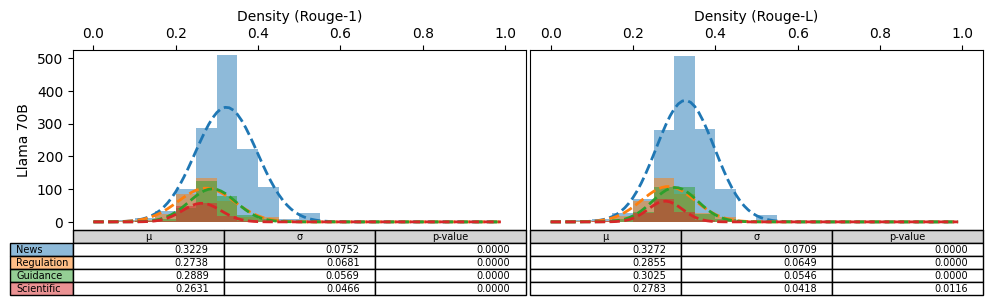

In [ ]:
# create figure:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

# plot columns:
colors = {'News':None, 'Regulation':None, 'Guidance':None, 'Scientific':None}
for i, col in enumerate(['rouge1', 'rougeL']):
    tab = []
    tab_col_names = ['μ', 'σ', 'p-value']
    tab_row_names = ['News', 'Regulation', 'Guidance', 'Scientific']
    ax = axs[i]

    for source_type in tab_row_names:
        scores = density_llama70b_per_type[source_type]

        if col.startswith('rouge'): x_min, x_max, x_step = 0., 1., .01
        else:                       x_min, x_max, x_step = -10., 0., .1
        bins = np.arange(x_min, x_max, x_step*5.)
        x = np.arange(x_min, x_max, x_step)

        # plot histogram:
        _, _, bars = ax.hist(scores[col], bins=bins, alpha=.5, color=colors[source_type])
        if colors[source_type] is None: colors[source_type] = bars[0].get_facecolor()

        # compute Shapiro-Wilk:
        W, p = shapiro(scores[col])

        # fit and plot normal distribution:
        mu, std = norm.fit(scores[col])
        y = norm.pdf(x, mu, std) * (len(scores) * x_step * 5.)
        ax.plot(x, y, ls='dashed', lw=2, alpha=1., color=colors[source_type])

        # layout:
        ax.set_xlim(x_min-.05*(x_max-x_min), x_max+.05*(x_max-x_min))
        ax.set_ylim(-25, 525)
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position('top')
        ax.set_xlabel(f'Density ({titles[col]})')
        if i == 0: ax.set_ylabel('Llama 70B')
        else: ax.set_yticks([])

        tab.append([f'{mu:.4f}', f'{std:.4f}', f'{p:.4f}'])

    table = plt_table(ax, cellText=tab, rowLabels=tab_row_names if i == 0 else None, rowColours=[colors[name] for name in tab_row_names] if i == 0 else None, colLoc='center', colLabels=tab_col_names, colColours=['lightgray']*len(tab_col_names))
    table.set_fontsize(7)

plt.subplots_adjust(wspace=.01, top=.85, bottom=.25, left=.08, right=.99)
plt.savefig('density_per_type_llama70b.pdf')
plt.show()